In [1]:
from iotbx.map_manager import map_manager as MapManager
from mmtbx.model import manager as ModelManager
from iotbx.data_manager import DataManager
from iotbx.map_model_manager import map_model_manager as MapModelManager
from mmtbx.maps.correlation import five_cc

In [2]:
import os
import pickle
from multiprocessing import Pool
from collections import Counter
import numpy as np
import gzip
import shutil

In [3]:
nucleotide_entries_path = "data/nucleotide_entries.pkl" # list of entries
working_directory = "../../maps_and_models_ligand_extracted" # directory of extracted densities and ligand models

In [4]:
entry_ids = os.listdir(working_directory)

with open(nucleotide_entries_path,"rb") as fh:
    nucleotide_entries = pickle.load(fh)
nucleotide_entries_dict = {entry.entry:entry for entry in nucleotide_entries if entry.entry in entry_ids}

In [5]:
# open all maps and models, calculate cross correlation
five_cc_obj_dict = {}
for entry_id in entry_ids:
    entry = nucleotide_entries_dict[entry_id]
    entry_directory = working_directory+"/"+entry_id
    contents = os.listdir(entry_directory)
    ligand_ids = list(set([f.split(".")[0] for f in contents if "ligand" in f]))
    
    for ligand_id in ligand_ids:
        ligand_map_path = entry_directory+"/"+ligand_id+".map"
        ligand_model_path = entry_directory+"/"+ligand_id+".pdb"
        dm = DataManager()
        dm.process_model_file(ligand_model_path)
        model_manager = dm.get_model()
        map_manager = MapManager(ligand_map_path)
        mmm = MapModelManager(map_manager=map_manager, model=model_manager)

        d_min = entry.resolution
        five_cc_obj = five_cc(
                       mmm.map_data(),
                       mmm.model().get_xray_structure(),
                       d_min,
                       box=None,
                       keep_map_calc=False,
                       compute_cc_box=False,
                       compute_cc_image=False,
                       compute_cc_mask=True,
                       compute_cc_volume=True,
                       compute_cc_peaks=True)

        five_cc_obj_dict[entry_id+"_"+ligand_id] = five_cc_obj

    

In [19]:
from collections import OrderedDict

In [20]:
# extract the cc_mask value to an array
cc_mask_dict = OrderedDict()

for i,(key,value) in enumerate(five_cc_obj_dict.items()):
    cc_mask = value.result()["cc_mask"]
    cc_mask_dict[key]=cc_mask
    
#cc_mask_array = np.array(cc_mask_values)

## Plot

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use("seaborn-notebook")
plot_scale = 0.5
font_scale = 2

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (16*plot_scale, 11*plot_scale),
         'axes.labelsize': 10*font_scale,
         'axes.titlesize':10*font_scale,
         'xtick.labelsize':10*font_scale,
         'ytick.labelsize':10*font_scale}
plt.rcParams.update(params)

Text(0.5,0,'CCmask')

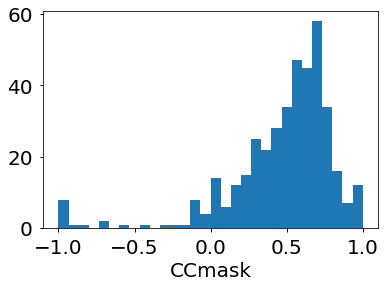

In [56]:
n,bins,patches = plt.hist(cc_mask_array,bins=30)
plt.xlabel("CCmask")

In [54]:
# find some examples
best_cc_key = max(cc_mask_dict,key=cc_mask_dict.get)
worst_cc_key = min(cc_mask_dict,key=cc_mask_dict.get)
cc_mask_values = np.array(cc_mask_dict.values())
def find_nearest(array, value,retidx=True):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    if retidx:
        return idx
    else:
        return array[idx]
zero_cc_key = cc_mask_dict.keys()[find_nearest(cc_mask_values,0)]
half_cc_key = cc_mask_dict.keys()[find_nearest(cc_mask_values,0.5)]

In [58]:
print("CC=1:",best_cc_key)
print("CC=0.5:",half_cc_key)
print("CC=0",zero_cc_key)
print("CC=-1:",worst_cc_key)


('CC=1:', '5mva_3576_ligand_ADP_I')
('CC=0.5:', '6oif_20076_ligand_ATP_R')
('CC=0', '5mva_3576_ligand_ADP_T')
('CC=-1:', '5mvy_3578_ligand_ADP_B')
